In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
path = "/content/drive/MyDrive/cat__and_dog_breed_classification/Notebook/Images/"

In [4]:
test_annotation = open("annotations/annotations/test.txt").readlines()
train_annotation = open("annotations/annotations/trainval.txt").readlines()

In [5]:
#Make dictionary for our classes
class_id = []
label = []
for x in test_annotation:
    class_name = x.split(' ')[0].replace("_"," ")
    cleaned_name = ''.join([i for i in class_name if not i.isdigit()])
    class_id.append(cleaned_name.rstrip())
    label.append(int(x.split(' ')[1])-1)

class_names = pd.DataFrame(class_id,label).drop_duplicates().to_dict()[0]


In [7]:
#Make a custom image dataset class to load into PyTorch

class CustomImageDataset(Dataset):
    def __init__(self, annotations_list, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_list
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx].split(' ')[0] + '.jpg')
        #image = read_image(img_path)
        image = Image.open(img_path).convert('RGB')
        label = int(self.img_labels[idx].split(' ')[1]) - 1 
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
train_dataset = CustomImageDataset(annotations_list=train_annotation,img_dir= "images/images",transform=data_transforms['train'])
test_dataset = CustomImageDataset(annotations_list=test_annotation,img_dir="images/images",transform=data_transforms['val'])

image_datasets = {'train': train_dataset, 'val': test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Make our data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [9]:
inputs, classes = next(iter(train_dataloader))

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

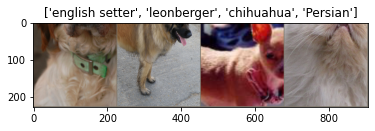

In [11]:
# Make a grid from batch and show some of the classes
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [12]:
# Make batch size a bigger for training
# Make our data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

dataloaders = {'train': train_dataloader , 'val': val_dataloader}

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(labels)
                    loss = criterion(outputs, labels)
                    #print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


c:\Users\user-pc\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 3.1254 Acc: 0.2478
val Loss: 2.0848 Acc: 0.6405

Epoch 1/24
----------
train Loss: 1.8744 Acc: 0.6465
val Loss: 1.1248 Acc: 0.8002

Epoch 2/24
----------
train Loss: 1.2680 Acc: 0.7663
val Loss: 0.7947 Acc: 0.8441

Epoch 3/24
----------
train Loss: 0.9887 Acc: 0.7959
val Loss: 0.6466 Acc: 0.8716

Epoch 4/24
----------
train Loss: 0.8389 Acc: 0.8177
val Loss: 0.5650 Acc: 0.8692

Epoch 5/24
----------
train Loss: 0.7562 Acc: 0.8236
val Loss: 0.4955 Acc: 0.8850

Epoch 6/24
----------
train Loss: 0.6725 Acc: 0.8492
val Loss: 0.4646 Acc: 0.8839

Epoch 7/24
----------
train Loss: 0.6333 Acc: 0.8476
val Loss: 0.4609 Acc: 0.8883

Epoch 8/24
----------
train Loss: 0.6257 Acc: 0.8500
val Loss: 0.4517 Acc: 0.8915

Epoch 9/24
----------
train Loss: 0.6425 Acc: 0.8470
val Loss: 0.4454 Acc: 0.8926

Epoch 10/24
----------
train Loss: 0.6121 Acc: 0.8522
val Loss: 0.4410 Acc: 0.8934

Epoch 11/24
----------
train Loss: 0.6007 Acc: 0.8606
val Loss: 0.4444 Acc: 0.8915

Epoch 12/24
----------
t

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

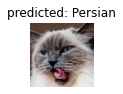

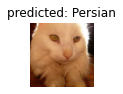

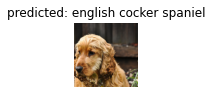

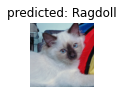

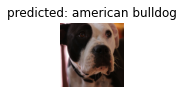

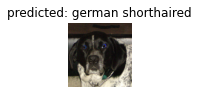

In [19]:
visualize_model(model_ft)

In [21]:
torch.save(model_ft.state_dict(), "model.pth")

In [61]:
inputs, labels = next(iter(test_dataloader))
inputs.to(device)
labels.to(device)

tensor([14, 33, 24, 28], device='cuda:0')

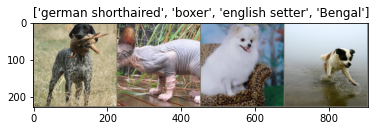

In [62]:
# Make a grid from batch and show some of the classes
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [22]:
torch.save(model_ft, "modelv1.pth")